# **Stratification of (MEP3) grades using *machine learning with clustering* rather than weighted averages**


## Background

Mechanical engineering practice 3 (MEP-III) is a course in which "students apply the engineering design process by combining engineering science with simulation tools to guide design decisions." In teams of ~4 students, created using CATME, they work on modeling a horizontal mover (such as a moving walkway, a tramcar, automated bookshelfs for a library...).  

In this course summative assessment is used through a weighted average of student scores in the categories: "homework", "exams", "team work".  "Homeworks" are individual student efforts, "team work" allows for leadership and group dynamics aspects to assert themselves, "exams" are individual effort with a more severe time constraint than "homework".   Typically, students have between 5-7 days to work on homeworks while exams are of 110 minute duration.  Teamwork in itself is a CATME weighted average of team deliverables.  Each member of a team, receives a portion of the total score on team deliverables.  This portion is dictated through peer-review scores that team members complete for each other, via CATME.

## The problem

The weighted average technique is not sensitive to the differing nature (of perhaps meta-skills required?) of student performance in the three categories.  This leads to students possessing different strengths being "***painted with the same brush***".  From anecdotal evidence, students have succeeded in circumventing CATME's capabilities and resorting to manipulating team members in such fashion that is not captured in CATME.

In the approach that follows, student summative assessment scores are stratified into clusters or groups using the K-Means clustering approach.  In contrast to the weighted average technique, this clustering approach stratifies students with similar score attributes.  This stratification is absent in the weighted average technique.  

# Preamble

In [0]:
#@title
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#plt.style.use('fivethirtyeight') #Plot style preferred by author.

import pandas as pd
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr

from tabulate import tabulate #pretty display of tables

import plotly.express as px
from plotly.subplots import make_subplots


#https://matplotlib.org/3.1.1/tutorials/colors/colormaps.html


# Importing data and preliminary visualization

In [8]:
#@title
#url = 'https://raw.githubusercontent.com/dnaneet/SVD_PCA/master/grading/mep3_f17_lg.csv'
url2 ='https://raw.githubusercontent.com/dnaneet/SVD_PCA/master/grading/mep3_f17_catme_121719.csv'

#url3= 'https://raw.githubusercontent.com/dnaneet/SVD_PCA/master/grading/mep3_s18.csv' 
df1 = pd.read_csv(url2, names=["homework", "teamwork", "exams", 
                               "total", "letter grade", "rank",
                               "CATME (early)", "CATME (final)", "CATME (avg)"])

performance = df1.values
scores = performance[:,0:3]
total = performance[:,3]
#print(df1.dtypes)

#df1["homework"] = df1["homework"]*100/200;
#df1["teamwork"] = df1["teamwork"]*100/400
#df1["exams"] = df1["exams"]*100/400
#df1["total"] = df1["total"]


df1["stdev"] = round(df1[["homework", "teamwork", "exams"]].T.std().T)

length_of_df=len(df1)
df1.columns
#sns.pairplot(df1.iloc[:,0:3], 
#             markers="+",
#             diag_kind='kde',
#             kind='reg')
#plt.ylim(0, 20)
#plt.xlim(0, 100)

hw_mean = df1[["homework"]].mean()
hw_stdev = df1[["homework"]].std()

tw_mean = df1[["teamwork"]].mean()
tw_stdev = df1[["teamwork"]].std()

exam_mean = df1[["exams"]].mean()
exam_stdev = df1[["exams"]].std()

print('Mean of homework, teamwork, exams\n', hw_mean, tw_mean, exam_mean)
print('STDEV of homework, teamwork, exams\n', hw_stdev, tw_stdev, exam_stdev)


print(tabulate(df1.sample(n=10, random_state=0),headers=df1.columns))

Mean of homework, teamwork, exams
 homework    84.925532
dtype: float64 teamwork    90.388298
dtype: float64 exams    68.718085
dtype: float64
STDEV of homework, teamwork, exams
 homework    11.956239
dtype: float64 teamwork    5.295369
dtype: float64 exams    9.591993
dtype: float64
       homework    teamwork    exams    total  letter grade      rank    CATME (early)    CATME (final)    CATME (avg)    stdev
---  ----------  ----------  -------  -------  --------------  ------  ---------------  ---------------  -------------  -------
107        92.5       87.25    67.5      80.4  B                    3               88               71           79.5       13
 45        98         94       76.25     87.7  AB                   2               76               80           78         12
160        86         91       52.5      74.6  C                    5               82               75           78.5       21
 63        91.5       85.25    65.75     78.7  BC                   4      

### Histogram of scores in each category

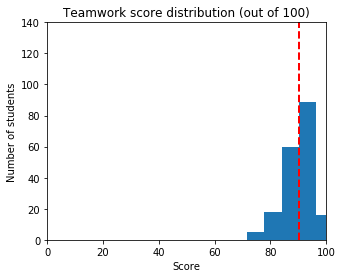

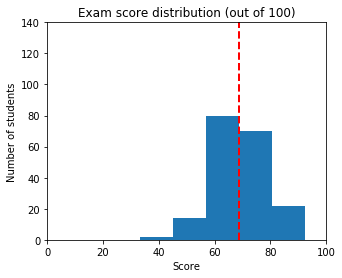

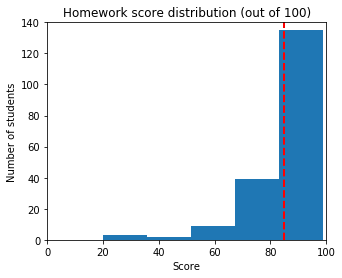

In [21]:
#@title
fig=plt.figure(figsize=(5,4))
#ax1 = fig.add_subplot(311)
df1["teamwork"].hist(bins=5)
plt.axvline(df1["teamwork"].mean(), 
            color='r', linestyle='dashed', linewidth=2)
plt.xlim((0, 100))
plt.ylim((0,140))
plt.title("Teamwork score distribution (out of 100)")
plt.xlabel('Score')
plt.ylabel('Number of students')
plt.grid(b=None)
plt.show()

#ax2 = fig.add_subplot(312)
fig=plt.figure(figsize=(5,4))
df1["exams"].hist(bins=5)
plt.axvline(df1["exams"].mean(), 
            color='r', linestyle='dashed', linewidth=2)
plt.xlim((0, 100))
plt.ylim((0,140))
plt.title("Exam score distribution (out of 100)")
plt.xlabel('Score')
plt.ylabel('Number of students')
plt.grid(b=None)
plt.show()

#ax3 = fig.add_subplot(313)
fig=plt.figure(figsize=(5,4))
df1["homework"].hist(bins=5)
plt.axvline(df1["homework"].mean(), 
            color='r', linestyle='dashed', linewidth=2)
plt.xlim((0, 100))
plt.ylim((0,140))
plt.title("Homework score distribution (out of 100)")
plt.xlabel('Score')
plt.ylabel('Number of students')
plt.grid(b=None)
plt.show()


(0, 150)

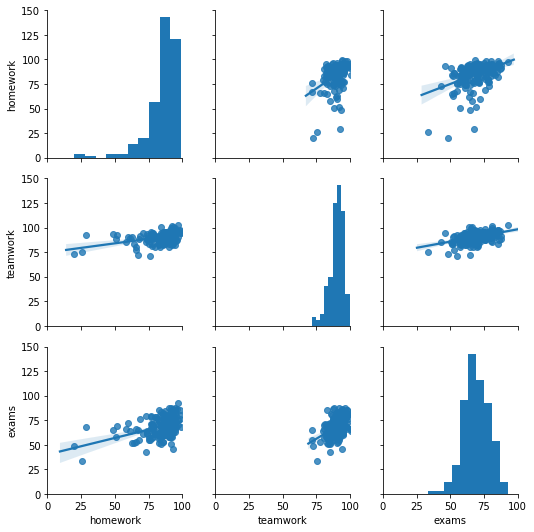

In [0]:
#@title
g = sns.pairplot(df1[['homework', 'teamwork', 'exams']], kind='reg')
g.axes[0,0].set_xlim((0,100))
g.axes[0,0].set_ylim((0,150))
g.axes[1,1].set_xlim((0,100))
g.axes[1,1].set_ylim((0,150))
g.axes[2,2].set_xlim((0,100))
g.axes[2,2].set_ylim((0,150))

### 3D scatter plot of scores in three categories

In [0]:
#@title
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(211, projection='3d')
ax.scatter(df1['homework'], df1['teamwork'], df1['exams'], s=80, c=df1['rank'], alpha=0.99)
#ax.view_init(90, 90)
plt.xlabel('Homework')
plt.ylabel('Teamwork')
#plt.zlabel('Exams')
plt.show()

### Dynamic visualization: "Mixing" of grades between BC -- F

In [23]:
#@title
import plotly.express as px
from plotly.subplots import make_subplots


fig = px.scatter_3d(df1.iloc[:,0:len(df1)+1], x='homework', y='teamwork', z='exams', 
                    color='letter grade',hover_data=['total']) #letter grade
fig.update_layout(scene = dict(
        xaxis = dict(nticks=4, range=[0,110],),
                     yaxis = dict(nticks=4, range=[0,110],),
                     zaxis = dict(nticks=4, range=[0,110],),),
                     margin=dict(r=20, l=10, b=10, t=10),
                  height=800, width=1200, title_text="letter grades")
fig.show()

# Data processing: scaling, principal component analysis, clustering

## Scaling

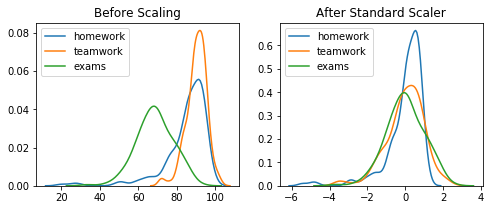

In [24]:
#@title
scaler = StandardScaler()
scores_scaled = scaler.fit_transform(df1[["homework", "teamwork", "exams"]])
#pri nt(scores)
type(scores_scaled)
#scores_scaled
df1_scaled = pd.DataFrame(scores_scaled, columns=['homework', 'teamwork', 'exams'])
df1_scaled.head(3)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 3))
ax1.set_title('Before Scaling')
sns.kdeplot(df1['homework'], ax=ax1)
sns.kdeplot(df1['teamwork'], ax=ax1)
sns.kdeplot(df1['exams'], ax=ax1)

ax2.set_title('After Standard Scaler')
sns.kdeplot(df1_scaled['homework'], ax=ax2)
sns.kdeplot(df1_scaled['teamwork'], ax=ax2)
sns.kdeplot(df1_scaled['exams'], ax=ax2)
plt.show()

## Principal component analysis

### PCA of unscaled grades



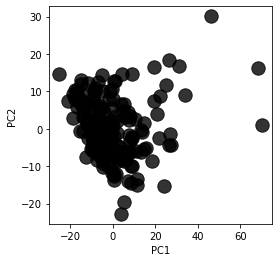

In [25]:
#@title
pca = sklearnPCA(n_components=2) #2-dimensional PCA
pca_scores = pca.fit_transform(df1.iloc[:,0:3])
#print(pca.explained_variance_ratio_)  
transformed = pd.DataFrame(pca_scores)
#print(transformed.head(5))
pca12 = np.array(transformed)

plt.figure(figsize=(4,4))
plt.scatter(pca12[:,0], pca12[:,1],  s=180, c='black', alpha=0.8)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


pca_df = pd.DataFrame({'pc1': pca12[:, 0], 'pc2': pca12[:, 1]})
#pca_df.head(5)

#fig=px.scatter(pca_df, x="pc1", y="pc2")
#fig.show()

### PCA of scaled grades

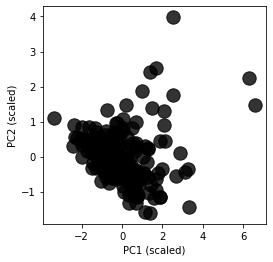

In [26]:
#@title
#StandardScaler modified
pca_scores_scaled = pca.fit_transform(df1_scaled)
#print(pca_scores_scaled.explained_variance_ratio_)  
transformed_scaled = pd.DataFrame(pca_scores_scaled)
#print(transformed.head(5))
pca12_scaled = np.array(transformed_scaled)

plt.figure(figsize=(4,4))
plt.scatter(pca12_scaled[:,0], pca12_scaled[:,1],  s=180, c='black', alpha=0.8)
plt.xlabel('PC1 (scaled)')
plt.ylabel('PC2 (scaled)')
plt.show()


## Visualization of the principal components

In [0]:
#@title
plt.figure(figsize=(8,1))
plt.scatter(pca12[:,0] ,np.zeros(len(total)), s=30)
plt.show()
plt.figure(figsize=(8,1))
plt.scatter(total, np.zeros(len(total)), s=30)

## Clustering

### K-Means clustering of raw grades (no scaling, no PCA)

#### Optimum number of clusters selected using Elbow plot and Euclidean distance between data points



1.  https://stackoverflow.com/questions/41540751/sklearn-kmeans-equivalent-of-elbow-method
2.   https://www.datanovia.com/en/lessons/determining-the-optimal-number-of-clusters-3-must-know-methods/#elbow-method



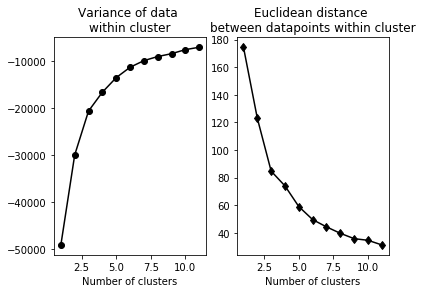

In [55]:
#@title
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

cMin=1
cMax=12
Ks = range(cMin, cMax)
km = [KMeans(n_clusters=i) for i in Ks]
score = [km[i].fit(df1[["homework", "teamwork", "exams"]]).score(df1[["homework", "teamwork", "exams"]]) for i in range(len(km))]

res = list()
x=df1[["homework", "teamwork", "exams"]]
n_cluster = range(cMin, cMax)
for n in n_cluster:
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(x)
    res.append(np.average(np.min(cdist(x, kmeans.cluster_centers_, 'euclidean'), axis=1))**2)


fig.tight_layout()

plt.subplot(1,2,1)
plt.plot(Ks, score, '-ok')
plt.xlabel('Number of clusters')
plt.title('Variance of data \nwithin cluster')
plt.plot()

plt.subplot(1,2,2)
plt.plot(n_cluster, res, '-dk')
plt.title('Euclidean distance \nbetween datapoints within cluster')
plt.xlabel('Number of clusters')
plt.show()

In [27]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
kmeans_raw = KMeans(n_clusters=6,random_state=0)
kmeans_raw.fit(df1[["homework", "teamwork", "exams"]])
labels_kmeans_raw = kmeans_raw.predict(df1[["homework", "teamwork", "exams"]])

#plt.figure(figsize=(6,6))
#plt.scatter(pca12[:, 0], pca12[:, 1], c=labels_kmean, s=220, cmap='prism', alpha=0.9)

#centers = kmeans.cluster_centers_
#print(centers)
#plt.scatter(centers[:, 0], centers[:, 1], c='black', s=500, alpha=0.65);
#plt.show()
df1["kmeans clusters (raw)"] = labels_kmeans_raw
df1.columns
#np.average(np.min(cdist(df1[["homework", "teamwork", "exams"]], kmeans_raw.cluster_centers_, 'euclidean'), axis=1))

Index(['homework', 'teamwork', 'exams', 'total', 'letter grade', 'rank',
       'CATME (early)', 'CATME (final)', 'CATME (avg)', 'stdev',
       'kmeans clusters (raw)'],
      dtype='object')

### K-Means clustering of PCA of unscaled grades

#### Optimum number of clusters selected using Elbow plot and Euclidean distance between data points

https://stackoverflow.com/questions/41540751/sklearn-kmeans-equivalent-of-elbow-method

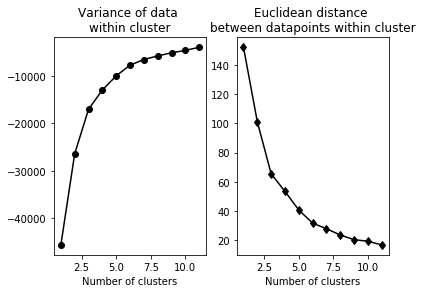

In [54]:
#@title
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

cMin=1
cMax=12
Ks = range(cMin, cMax)
km = [KMeans(n_clusters=i) for i in Ks]
score = [km[i].fit(pca12).score(pca12) for i in range(len(km))]

res = list()
x=pca12
n_cluster = range(cMin, cMax)
for n in n_cluster:
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(x)
    res.append(np.average(np.min(cdist(x, kmeans.cluster_centers_, 'euclidean'), axis=1))**2)


fig.tight_layout()

plt.subplot(1,2,1)
plt.plot(Ks, score, '-ok')
plt.xlabel('Number of clusters')
plt.title('Variance of data \nwithin cluster')
plt.plot()

plt.subplot(1,2,2)
plt.plot(n_cluster, res, '-dk')
plt.title('Euclidean distance \nbetween datapoints within cluster')
plt.xlabel('Number of clusters')
plt.show()

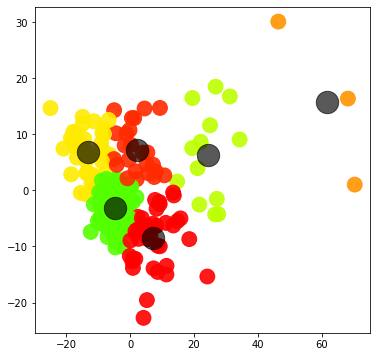

Index(['homework', 'teamwork', 'exams', 'total', 'letter grade', 'rank',
       'CATME (early)', 'CATME (final)', 'CATME (avg)', 'stdev',
       'kmeans clusters (raw)', 'kmeans clusters (raw/PCA)'],
      dtype='object')

In [28]:
#@title
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6,random_state=0)
kmeans.fit(pca12)
labels_kmean = kmeans.predict(pca12)

plt.figure(figsize=(6,6))
plt.scatter(pca12[:, 0], pca12[:, 1], c=labels_kmean, s=220, cmap='prism', alpha=0.9)

centers = kmeans.cluster_centers_
#print(centers)
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=500, alpha=0.65);
plt.show()

df1["kmeans clusters (raw/PCA)"] = labels_kmean
df1.columns

### K-Means clustering of using PCA of scaled grades

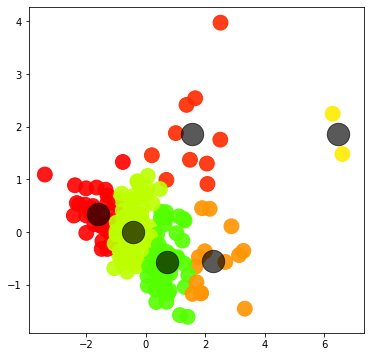

In [29]:
#@title
#@K-Means clustering of StandardScaled data
from sklearn.cluster import KMeans
kmeans2 = KMeans(n_clusters=6,random_state=0)
kmeans2.fit(pca12_scaled)
labels_kmean_2 = kmeans2.predict(pca12_scaled)

plt.figure(figsize=(6,6))
plt.scatter(pca12_scaled[:, 0], pca12_scaled[:, 1], c=labels_kmean_2, s=220, cmap='prism', alpha=0.9)

centers2 = kmeans2.cluster_centers_
#print(centers2)
plt.scatter(centers2[:, 0], centers2[:, 1], c='black', s=500, alpha=0.65);
plt.show()

df1["kmeans clusters (scaled/PCA)"] = labels_kmean_2

### Spectral clustering (under development)

In [0]:
#@title
from sklearn.cluster import SpectralClustering
spectral = SpectralClustering(n_clusters=6, affinity='nearest_neighbors',
                           assign_labels='kmeans',random_state=0)
labels_spectral = spectral.fit_predict(pca12)

plt.figure(figsize=(3,3))
plt.scatter(pca12[:, 0], pca12[:, 1], c=labels_spectral, s=60, cmap='viridis', alpha=0.85)


# Visualization of student scores in terms of letter grade vs clusters

In [59]:
df1.columns
#df1.sample(n=5, random_state=0)

Index(['homework', 'teamwork', 'exams', 'total', 'letter grade', 'rank',
       'CATME (early)', 'CATME (final)', 'CATME (avg)', 'stdev',
       'kmeans clusters (raw)', 'kmeans clusters (raw/PCA)',
       'kmeans clusters (scaled/PCA)'],
      dtype='object')

### Visualization of letter grade

In [60]:
fig = px.scatter_3d(df1.iloc[:,0:len(df1)+1], x='homework', y='teamwork', z='exams', 
                    color='letter grade',hover_data=['total'])
fig.update_layout(scene = dict(
        xaxis = dict(nticks=4, range=[0,110],),
                     yaxis = dict(nticks=4, range=[0,110],),
                     zaxis = dict(nticks=4, range=[0,110],),),
                     margin=dict(r=20, l=10, b=10, t=10))
fig.show()

### Visualization of scores painted by K-Means clusters of raw grades

In [61]:
fig = px.scatter_3d(df1.iloc[:,0:len(df1)+1], x='homework', y='teamwork', z='exams', 
                    color='kmeans clusters (raw)',hover_data=['total'])
fig.update_layout(scene = dict(
        xaxis = dict(nticks=4, range=[0,110],),
                     yaxis = dict(nticks=4, range=[0,110],),
                     zaxis = dict(nticks=4, range=[0,110],),),
                     margin=dict(r=20, l=10, b=10, t=10))
fig.show()

# Visualizing scores colored by kmeans clusters of PCA of raw grades

In [62]:
fig = px.scatter_3d(df1.iloc[:,0:len(df1)+1], x='homework', y='teamwork', z='exams', 
                    color='kmeans clusters (raw/PCA)',hover_data=['total'])
fig.update_layout(scene = dict(
        xaxis = dict(nticks=4, range=[0,110],),
                     yaxis = dict(nticks=4, range=[0,110],),
                     zaxis = dict(nticks=4, range=[0,110],),),
                     margin=dict(r=20, l=10, b=10, t=10))
fig.show()

### Visualizing scores colored by kmeans clusters of PCA of scaled grades

In [0]:
fig = px.scatter_3d(df1.iloc[:,0:len(df1)+1], x='homework', y='teamwork', z='exams', 
                    color='kmeans clusters (scaled/PCA)',hover_data=['total'])
fig.update_layout(scene = dict(
        xaxis = dict(nticks=4, range=[0,110],),
                     yaxis = dict(nticks=4, range=[0,110],),
                     zaxis = dict(nticks=4, range=[0,110],),),
                     margin=dict(r=20, l=10, b=10, t=10))
fig.show()

In [30]:
df1.columns

Index(['homework', 'teamwork', 'exams', 'total', 'letter grade', 'rank',
       'CATME (early)', 'CATME (final)', 'CATME (avg)', 'stdev',
       'kmeans clusters (raw)', 'kmeans clusters (raw/PCA)',
       'kmeans clusters (scaled/PCA)'],
      dtype='object')

In [0]:
df1.to_csv('processed_data.csv', encoding='utf-8', index=False)
from google.colab import files
files.download("processed_data.csv")    

In [0]:
c = df2[df2['rank']==5]
#print(c[['total', 'kmeans cluster']])

f = df2[df2['rank']==6]
#print(f[['total', 'kmeans cluster']])

a = df2[df2['rank']==1]
#print(a[['total', 'kmeans cluster']])

b = df2[df2['rank']==2]
print(b[['total', 'kmeans cluster']].sample(n=10, random_state=1))

# Inclusion of CATME evaluation scores (in development)

### PairPlot between homework, teamwork and exams

In [0]:
df2.head(2)
df2_catme=df2.sort_values(by=['total']);
#print(tabulate(df2_catme, headers=['homework', 'teamwork', 'exams', 'letter grade', 'rank', 'CATME1', 'CATME2', 'CATME (avg)', 'Cluster']))
g = sns.pairplot(df2_catme[['homework', 'teamwork', 'exams']].iloc[0:50,:], kind='reg')
g.axes[0,0].set_xlim((0,100))
g.axes[0,0].set_ylim((0,150))
g.axes[1,1].set_xlim((0,100))
g.axes[1,1].set_ylim((0,150))
g.axes[2,2].set_xlim((0,100))
g.axes[2,2].set_ylim((0,150))


### PairPlot between teamwork and CATME (avg) shows little to no correlation

In [0]:
df2.head(2)
df2_catme=df2.sort_values(by=['CATME (avg)']);
#print(tabulate(df2_catme, headers=['homework', 'teamwork', 'exams', 'letter grade', 'rank', 'CATME1', 'CATME2', 'CATME (avg)', 'Cluster']))
g = sns.pairplot(df2_catme[['teamwork', 'CATME (avg)']])
g.axes[0,0].set_xlim((0,100))
g.axes[0,0].set_ylim((0,150))
g.axes[1,1].set_xlim((0,100))
g.axes[1,1].set_ylim((0,150))


### PairPlot between rank and cluster number

In [0]:
df2.head(2)
g = sns.pairplot(df2_catme[['total', 'kmeans cluster']], hue="kmeans cluster")


In [0]:
#@title
fig = px.scatter_3d(df2.iloc[:,0:11], x='homework', y='teamwork', z='exams', 
                    color='CATME (avg)')
fig.update_layout(scene = dict(
        xaxis = dict(nticks=4, range=[0,110],),
                     yaxis = dict(nticks=4, range=[0,110],),
                     zaxis = dict(nticks=4, range=[0,110],),),
                     margin=dict(r=20, l=10, b=10, t=10))
fig.show()